In [25]:
import matplotlib
import pathlib

import mne
print(mne.__version__)

from scipy.io import loadmat, savemat
from fracModel import fracOrdUU
import os
import numpy as np

0.23.0


In [26]:
matplotlib.use('Qt5Agg')

In [27]:
#Locations - Sahil
location_av = "D:\Documents\CS637 project\Original Dataset\data_set_IVa_av_mat\\100Hz\data_set_IVa_av.mat"

In [28]:
import scipy.io
mat = scipy.io.loadmat(location_av)

In [29]:
def get_A(X):
    
    meanX = np.mean(X, axis=1)
    X = X.T - meanX
    X = X.T
    fModel = fracOrdUU(verbose=1)
    fModel.fit(X)
    
    return fModel._AMat[-1]

In [30]:
sfreq = mat['nfo']['fs'][0][0][0][0]

EEGdata = mat['cnt'].T
EEGdata = 1e-1*EEGdata   #To convert to uV

nchannels, nsamples = EEGdata.shape

ch_names = [s[0] for s in mat['nfo']['clab'][0][0][0]]

event_onsets = mat['mrk'][0][0][0]
event_codes = mat['mrk'][0][0][1]

labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in mat['mrk']['className'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]

xpos = mat['nfo']['xpos'][0][0]
ypos = mat['nfo']['ypos'][0][0]

nclasses = len(cl_lab)
nevents = len(event_onsets.transpose())

In [31]:
trials = {}

win = np.arange(int(0*sfreq), int(3*sfreq))    # Epoch size of each trial (0 to 3 sec)
nsamples = len(win)

In [32]:
for cl, code in zip(cl_lab, np.unique(event_codes)):
    cl_onsets = event_onsets[event_codes == code]
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    for i, onset in enumerate(cl_onsets):
        trials[cl][:, :, i] = EEGdata[:, win+onset]

In [33]:
right = np.rollaxis(trials[cl1], 2, 0)
foot = np.rollaxis(trials[cl2], 2, 0)

In [34]:
data = np.concatenate([right, foot])

In [35]:
Y = np.concatenate([-np.ones(right.shape[0]), np.ones(foot.shape[0])])    # Labeling right as -1 and foot as 1

In [36]:
# Converting to BIDS using mne
n_channels = 118

info = mne.create_info(
ch_names = ch_names,
ch_types = ['eeg']*nchannels,
sfreq = sfreq)

layout_pos = np.concatenate([xpos, ypos], axis = 1)

layout = mne.channels.generate_2d_layout(
xy = layout_pos,
ch_names = ch_names,
name = "EEG custom layout")

In [37]:
event_id = dict(right = -1, foot = 1)

eventLength = Y.shape[0]
ev = [i*sfreq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev, dtype = int),
                         np.zeros(eventLength, dtype = int),
                         np.array(Y, dtype = int)))

In [38]:
tmin = 0
epochs = mne.EpochsArray(data, info, events, tmin, event_id)

Not setting metadata
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [39]:
final_ch_list = ["T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8"] #Channels which affect motor controls the most

In [40]:
#epochs.plot(picks = final_ch_list);

In [41]:
edata = epochs.get_data(picks = final_ch_list)
edata.shape

(84, 9, 300)

In [42]:
edata[0]

array([[-18.1, -23. , -20.9, ..., -28.5, -21. , -15.4],
       [ 38.4,  16.2,  24.1, ...,  24. ,  37.4,  42.7],
       [ -2.7, -11.4,  -6.7, ..., -12.9,  -1.4,   4.5],
       ...,
       [ 30.5,  24. ,  19.2, ...,  14.3,  23.3,  20.3],
       [ 46.9,  44. ,  38.9, ...,  35.4,  41.9,  42.2],
       [ -9.7,  -2.8,  -6.9, ..., -15.4, -21.3, -12. ]])

In [43]:
Y.shape

(84,)

In [44]:
Adata = np.stack([get_A(x) for x in edata])

beginning mse = 50.926260
iter ind = 0, mse = 13.339534
iter ind = 1, mse = 13.333724
iter ind = 2, mse = 13.332888
time taken = 27.585246
beginning mse = 36.961349
iter ind = 0, mse = 12.842891
iter ind = 1, mse = 12.841140
iter ind = 2, mse = 12.839545
time taken = 22.322572
beginning mse = 33.095075
iter ind = 0, mse = 5.352550
iter ind = 1, mse = 5.352696
iter ind = 2, mse = 5.352672
time taken = 18.607890
beginning mse = 32.007200
iter ind = 0, mse = 5.453526
iter ind = 1, mse = 5.452336
iter ind = 2, mse = 5.451301
time taken = 24.617291
beginning mse = 39.676145
iter ind = 0, mse = 9.782632
iter ind = 1, mse = 9.780172
iter ind = 2, mse = 9.779159
time taken = 15.198493
beginning mse = 45.108474
iter ind = 0, mse = 17.128553
iter ind = 1, mse = 17.125794
iter ind = 2, mse = 17.124253
time taken = 24.666912
beginning mse = 38.304092
iter ind = 0, mse = 7.473922
iter ind = 1, mse = 7.472242
iter ind = 2, mse = 7.471290
time taken = 21.956968
beginning mse = 59.742933
iter ind = 0,

In [45]:
np.savez('Adataav.npz', Adata = Adata, Y = Y)

#### Feature extraction

In [54]:
# Loading Data
Adata = np.load("Adata.npz")["Adata"]
Y = np.load("Adata.npz")["Y"]

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
print(np.sum(Y<0)) #Checking number of "right" events

112


In [57]:
ARight = np.average(Adata[0:112], axis = 0)
AFoot = np.average(Adata[112:], axis = 0)

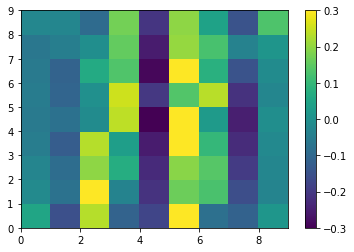

In [58]:
fig = plt.figure()
f = plt.pcolormesh(ARight, vmin=-0.3, vmax=0.3)
plt.colorbar(f)

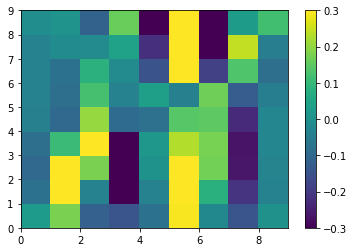

In [59]:
fig = plt.figure()
f = plt.pcolormesh(AFoot, vmin=-0.3, vmax=0.3)
plt.colorbar(f)

## Applying ML

In [60]:
X = np.stack([np.concatenate([a[:, 1], a[:, 3]]) for a in Adata])

In [61]:
X.shape

(224, 18)

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#### Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
Logclassifier = LogisticRegression(random_state = 0)
Logclassifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
y_pred_log = Logclassifier.predict(X_test)

In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_log)
print(cm)

[[19  3]
 [ 1 22]]


In [66]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Logclassifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 89.90 %
Standard Deviation: 7.87 %


#### Kernal SVM

In [67]:
from sklearn.svm import SVC
SVCclassifier = SVC(kernel = 'rbf', random_state = 0)
SVCclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [68]:
y_pred_SVC = SVCclassifier.predict(X_test)

In [69]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_SVC)
print(cm)
accuracy_score(y_test, y_pred_SVC)

[[19  3]
 [ 2 21]]


0.8888888888888888

#### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
RFclassifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [71]:
y_pred_RF = RFclassifier.predict(X_test)

In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_RF)
print(cm)
accuracy_score(y_test, y_pred_RF)

[[19  3]
 [ 2 21]]


0.8888888888888888

#### KNN

In [73]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit

In [74]:
from sklearn.neighbors import KNeighborsClassifier
KNNclassifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNNclassifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [75]:
y_pred_KNN = KNNclassifier.predict(X_test)

In [76]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_KNN)
print(cm)
accuracy_score(y_test, y_pred_KNN)

[[19  3]
 [ 3 20]]


0.8666666666666667

#### Naive Bayes

In [77]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [78]:
y_pred_NB = NBclassifier.predict(X_test)

In [79]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_NB)
print(cm)
accuracy_score(y_test, y_pred_NB)

[[20  2]
 [ 3 20]]


0.8888888888888888

In [81]:
from sklearn.metrics import roc_curve, auc

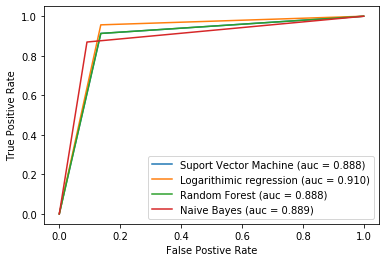

In [87]:
log_fpr, log_tpr, threshold = roc_curve(y_test, y_pred_log)
auc_log = auc(log_fpr, log_tpr)
SVC_fpr, SVC_tpr, threshold = roc_curve(y_test, y_pred_SVC)
auc_SVC = auc(SVC_fpr, SVC_tpr)
RF_fpr, RF_tpr, threshold = roc_curve(y_test, y_pred_RF)
auc_RF = auc(RF_fpr, RF_tpr)
KNN_fpr, KNN_tpr, threshold = roc_curve(y_test, y_pred_KNN)
auc_KNN = auc(KNN_fpr, KNN_tpr)
NB_fpr, NB_tpr, threshold = roc_curve(y_test, y_pred_NB)
auc_NB = auc(NB_fpr, NB_tpr)

plt.figure()
plt.plot(SVC_fpr, SVC_tpr, linestyle = '-', label = "Suport Vector Machine (auc = %0.3f)"%auc_SVC)
plt.plot(log_fpr, log_tpr, linestyle = '-', label = "Logarithimic regression (auc = %0.3f)"%auc_log)
plt.plot(RF_fpr, RF_tpr, linestyle = '-', label = "Random Forest (auc = %0.3f)"%auc_RF)
#plt.plot(KNN_fpr, KNN_tpr, linestyle = '-', label = "K-Nearest Neighbors (auc = %0.3f)"%auc_KNN)
plt.plot(NB_fpr, NB_tpr, linestyle = '-', label = "Naive Bayes (auc = %0.3f)"%auc_NB)

plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.show()

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

In [89]:
dict = {-1: 0,1: 1}

for i in range(len(y_train)):
    y_train[i] = dict[y_train[i]]
    
num_classes = 2
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

In [144]:
for i in range(len(y_test)):
    y_test[i] = dict[y_test[i]]
    
num_classes = 2
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [145]:
ip = tf.keras.Input(shape = 18)
dense1 = tf.keras.layers.Dense(units = 32, activation = "relu")(ip)
dense2 = tf.keras.layers.Dense(units = 32, activation = "relu")(dense1)
dense3 = tf.keras.layers.Dense(units = 16, activation = "relu")(dense2)
dense4 = tf.keras.layers.Dense(units = 8, activation = "relu")(dense3)
dense4 = tf.keras.layers.Dense(units = 2, activation = "sigmoid")(ip)

Model = tf.keras.models.Model(inputs = ip, outputs = dense4)
Model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 38        
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [146]:
Model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [147]:
history = Model.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test))

Epoch 1/200
6/6 [==============================] - 1s 51ms/step - loss: 0.7897 - acc: 0.4413 - val_loss: 0.7535 - val_acc: 0.5111
Epoch 2/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7828 - acc: 0.4413 - val_loss: 0.7457 - val_acc: 0.5111
Epoch 3/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7762 - acc: 0.4302 - val_loss: 0.7381 - val_acc: 0.5333
Epoch 4/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7695 - acc: 0.4469 - val_loss: 0.7308 - val_acc: 0.5333
Epoch 5/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7627 - acc: 0.4581 - val_loss: 0.7234 - val_acc: 0.5333
Epoch 6/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7567 - acc: 0.4749 - val_loss: 0.7160 - val_acc: 0.5556
Epoch 7/200
6/6 [==============================] - 0s 5ms/step - loss: 0.7501 - acc: 0.4916 - val_loss: 0.7091 - val_acc: 0.5778
Epoch 8/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7441 - acc: 0.5140 - va

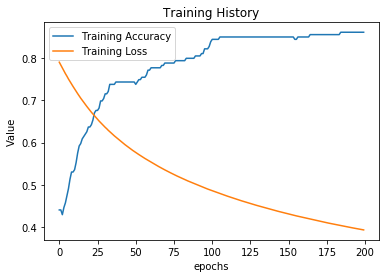

Initial training accuracy with preprocessing is:  0.44134077429771423
Final training accuracy with preprocessing is:  0.8603351712226868
Initial training loss with preprocessing is:  0.7896841168403625
Final training loss with preprocessing is:  0.39423835277557373


In [148]:
#Plotting model history
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", history.history['loss'][0])
print("Final training loss with preprocessing is: ", history.history['loss'][-1])

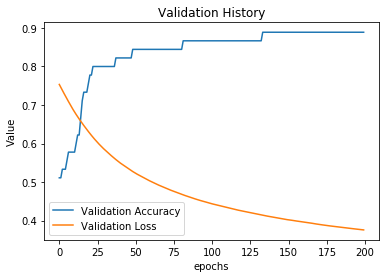

Initial Validation accuracy is:  0.5111111402511597
Best Validation accuracy is:  0.8888888955116272
Initial Validation loss is:  0.7534509301185608
Best Validation loss is:  0.37588629126548767


In [150]:
#Plotting model history
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.legend(['Validation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy is: ", history.history['val_acc'][0])
print("Best Validation accuracy is: ", max(history.history['val_acc']))

print("Initial Validation loss is: ", history.history['val_loss'][0])
print("Best Validation loss is: ", min(history.history['val_loss']))